# **Daten einlesen**

In [1]:
from google.colab import files

uploaded = files.upload() #hier kaggle API key hochladen

Saving kaggle(1).json to kaggle(1).json


In [2]:
!pwd

/content


In [3]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [101]:
!kaggle datasets download -d rtatman/british-birdsong-dataset

british-birdsong-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip british-birdsong-dataset.zip

## **Preprocessing**

In [8]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.30.0
    Uninstalling tensorflow-io-gcs-filesystem-0.30.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.30.0


In [9]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import re
from matplotlib import pyplot as plt

In [10]:
metadata = pd.read_csv("birdsong_metadata.csv")

In [11]:
song_path = "/content/songs/"

In [12]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import io
from pydub import AudioSegment

def flac_to_wav(filename):
  flac = AudioSegment.from_file(f"{song_path}songs/{filename}", format='flac')
  flac.export(f"{song_path}{filename[:-5]}.wav", format='wav')

In [40]:
def load_file(filename):
    #.wav einlesen
    song = tf.io.read_file(filename)
    #wellenlänge und sample rate auslesen
    w, sr = tf.audio.decode_wav(song, desired_channels = 1)
    #Dimensionen reduzieren
    w = tf.squeeze(w, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)
    #Lautstärke regeln
    w = tfio.audio.resample(w, rate_in=sr, rate_out=16000)
    #Wellenlängen zurückgegben
    return w

In [15]:
metadata["wave_length"] = ""

def wave_length_to_df(wave, file_id):
  metadata.loc[metadata["file_id"] == int(file_id[2:-4]), "wave_length"] = len(wave)

In [20]:
directory = os.fsencode(song_path+"/songs")

for file in os.listdir(directory):
  file_id = os.fsdecode(file)
  flac_to_wav(file_id)
  file_id = file_id[:-5] + ".wav"
  chirp_wave = load_file(song_path + file_id)
  wave_length_to_df(chirp_wave, file_id)

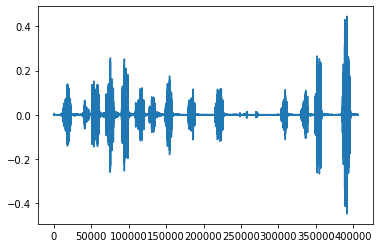

In [21]:
from matplotlib import pyplot as plt
chirp = load_file(song_path+"xc101371.wav")
plt.plot(chirp)

In [102]:
from IPython.display import Audio 
Audio(song_path+"xc101371.wav")

In [22]:
import shutil
shutil.rmtree("/content/songs/songs") #.flac Dateien löschen

In [23]:
metadata

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,wave_length
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,616907
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,203128
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,81084
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,259552
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,206889
...,...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/,4012404
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,693500
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,1171118
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,2056773


In [24]:
songs = tf.data.Dataset.list_files("/content/songs/*.wav")

In [27]:
from sklearn.preprocessing import LabelEncoder
import keras

label = metadata["english_cname"]
encoder = LabelEncoder()
encoder.fit(label)
label = encoder.transform(label)

In [28]:
metadata = metadata.assign(label = label)

In [29]:
ordered_labs = [] #Labels sollen im tf Dataset zum file passen
for file in list(songs.as_numpy_iterator()):
  ordered_labs.append(int(metadata.loc[metadata["file_id"] == int(file[17:-4]),"label"]))

In [30]:
dummy_labels = keras.utils.to_categorical(ordered_labs, len(set(ordered_labs)), dtype='float32')

In [31]:
dummy_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
labels = tf.data.Dataset.from_tensor_slices(dummy_labels)

In [33]:
data = tf.data.Dataset.zip((songs, labels))

In [35]:
metadata.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,wave_length,label
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,616907,16
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,203128,16
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,81084,16
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,259552,64
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,206889,64


In [34]:
metadata["wave_length"].mean()

1073719.3522727273

In [36]:
metadata["wave_length"].min()

52241

In [37]:
metadata["wave_length"].max()

4034876

Werds mit 100.000 versuchen liegt ein bisschen über dem min

In [38]:
def preprocess(file_path, label): 
    wav = load_file(file_path) #file_path zu filename schneiden
    wav = wav[:100000]
    #Padding um Clips die kürzer sind aufs Maximum zu bringen (mit 0en auffüllen)
    zero_padding = tf.zeros([100000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    #Dimensionserweiterung für das CNN später
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [84]:
file_content, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectogramm, label = preprocess(file_content, label)

In [85]:
metadata[metadata["file_id"] == int(str(file_content)[19:-5])]["english_cname"] #Welcher Vogel ists?

231    Eurasian Blackcap
Name: english_cname, dtype: object

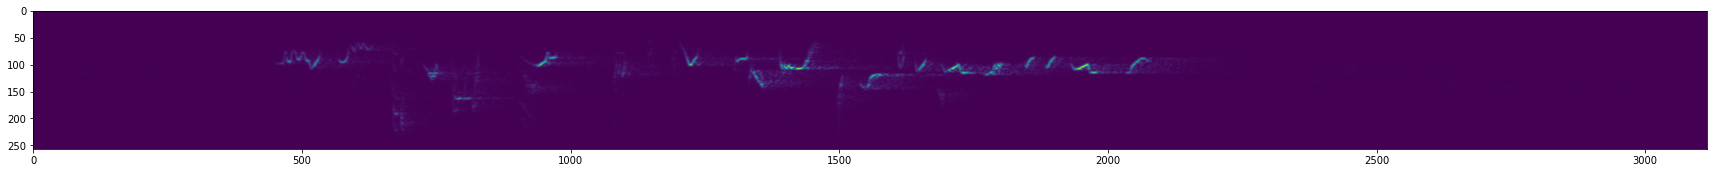

In [86]:
plt.figure(figsize=(30,20))  #Gesang visualisiert
plt.imshow(tf.transpose(spectogramm)[0])
plt.show()

# **Training**

In [87]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(4)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
len(data)

66

In [89]:
train = data.take(40)
val = data.skip(40).take(13)
test = data.skip(54).take(12)

In [ ]:
train.as_numpy_iterator()

In [90]:
samples, label = train.as_numpy_iterator().next()
samples.shape

(4, 3116, 257, 1)

In [91]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [92]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3116, 257, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(88, activation = 'softmax'))

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3114, 255, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1557, 127, 32)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1555, 125, 64)     18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 777, 62, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 775, 60, 64)       36928     
                                                                 
 flatten (Flatten)           (None, 2976000)           0

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
bird_classifier = model.fit(train, epochs=5, validation_data = val)

Epoch 1/5
36/40 [==========================>...] - ETA: 36s - loss: 5.3261 - accuracy: 0.0139

# **Evaluation**

In [98]:
bird_classifier.history

{'loss': [5.241552829742432,
  4.45883321762085,
  4.142863750457764,
  2.891465902328491,
  1.8193235397338867],
 'accuracy': [0.012500000186264515,
  0.07500000298023224,
  0.23125000298023224,
  0.5249999761581421,
  0.7749999761581421],
 'val_loss': [4.468511581420898,
  4.0624003410339355,
  3.3117787837982178,
  1.9715098142623901,
  0.8956747651100159],
 'val_accuracy': [0.11538461595773697,
  0.2884615361690521,
  0.557692289352417,
  0.7692307829856873,
  0.8653846383094788]}

In [105]:
X_test, y_test = test.as_numpy_iterator().next()
y_pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [104]:
model.evaluate(test)

12/12 [==============================] - 28s 2s/step - loss: 1.0913 - accuracy: 0.8542


[1.09128999710083, 0.8541666865348816]

In [ ]:
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)

1/1 [==============================] - 2s 2s/step
predictions shape: (4, 88)
